<a href="https://colab.research.google.com/github/marianvinas/DS-Unit-2-Kaggle-Challenge/blob/master/Marian_VinasCopy_of_DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0
13954,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0
13955,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0


In [0]:
df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'game_date', 'htm', 'vtm',
       'season_type', 'scoremargin_before_shot'],
      dtype='object')

In [0]:
df.dtypes

game_id                      int64
game_event_id                int64
player_name                 object
period                       int64
minutes_remaining            int64
seconds_remaining            int64
action_type                 object
shot_type                   object
shot_zone_basic             object
shot_zone_area              object
shot_zone_range             object
shot_distance                int64
loc_x                        int64
loc_y                        int64
shot_made_flag               int64
game_date                   object
htm                         object
vtm                         object
season_type                 object
scoremargin_before_shot    float64
dtype: object

In [0]:
import numpy as np

#train/test split, Regular season and playoff games, from October 28, 2009, through June 5, 2019.
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=False)
#cutoff = pd.to_datetime('2018-10-01')

train = df[df.game_date < '2018-10-01']
test  = df[df.game_date >= '2018-10-01']

In [0]:
train.shape, test.shape

((12249, 20), (1709, 20))

In [0]:
train['shot_made_flag'].mean()

0.4738345987427545

In [0]:
target = 'shot_made_flag'
y_train = train[target]
y_test = test[target]

In [0]:
guess = y_train.mean()
guess

0.4738345987427545

In [0]:
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Baseline accuracy: {mae:.2f} ')

Baseline accuracy: 0.50 


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
test.shape

(1709, 20)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
target = 'shot_made_flag'
high_cardinality = ['action_type']
features = train.columns.drop(high_cardinality + [target]).to_list()
features

['game_id',
 'game_event_id',
 'player_name',
 'period',
 'minutes_remaining',
 'seconds_remaining',
 'shot_type',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_zone_range',
 'shot_distance',
 'loc_x',
 'loc_y',
 'game_date',
 'htm',
 'vtm',
 'season_type',
 'scoremargin_before_shot']

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
X_train.shape

(12249, 18)

In [0]:
import category_encoders as ce 

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

In [0]:
X_train_enc

,game_id,game_event_id,player_name_Stephen Curry,period,minutes_remaining,seconds_remaining,shot_type_3PT Field Goal,shot_type_2PT Field Goal,shot_zone_basic_Above the Break 3,shot_zone_basic_Mid-Range,shot_zone_basic_In The Paint (Non-RA),shot_zone_basic_Restricted Area,shot_zone_basic_Left Corner 3,shot_zone_basic_Right Corner 3,shot_zone_basic_Backcourt,shot_zone_area_Right Side Center(RC),shot_zone_area_Left Side Center(LC),shot_zone_area_Center(C),shot_zone_area_Left Side(L),shot_zone_area_Right Side(R),shot_zone_area_Back Court(BC),shot_zone_range_24+ ft.,shot_zone_range_16-24 ft.,shot_zone_range_8-16 ft.,shot_zone_range_Less Than 8 ft.,shot_zone_range_Back Court Shot,shot_distance,loc_x,loc_y,game_date,htm_GSW,htm_PHX,htm_SAC,htm_IND,htm_MIL,htm_CLE,htm_BOS,htm_DAL,htm_SAS,htm_DEN,...,htm_TOR,htm_WAS,htm_NYK,htm_BKN,htm_NOP,vtm_HOU,vtm_GSW,vtm_MEM,vtm_LAC,vtm_MIN,vtm_POR,vtm_LAL,vtm_IND,vtm_ORL,vtm_SAS,vtm_WAS,vtm_PHX,vtm_BOS,vtm_SAC,vtm_CLE,vtm_MIA,vtm_MIL,vtm_CHI,vtm_DEN,vtm_NJN,vtm_NOH,vtm_CHA,vtm_OKC,vtm_DAL,vtm_UTA,vtm_ATL,vtm_PHI,vtm_DET,vtm_TOR,vtm_NYK,vtm_BKN,vtm_NOP,season_type_Regular Season,season_type_Playoffs,scoremargin_before_shot
0,20900015,4,1,1,11,25,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,26,99,249,2009-10-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.0
1,20900015,17,1,1,9,31,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,18,-122,145,2009-10-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
2,20900015,53,1,1,6,2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,14,-60,129,2009-10-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-4.0
3,20900015,141,1,2,9,49,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,19,-172,82,2009-10-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-4.0
4,20900015,249,1,2,2,19,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,16,-68,148,2009-10-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12244,41700404,582,1,4,6,19,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,24,-240,0,2018-06-08,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25.0
12245,41700404,588,1,4,5,48,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,14,-115,89,2018-06-08,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28.0
12246,41700404,591,1,4,5,13,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,34,-116,330,2018-06-08,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26.0
12247,41700404,603,1,4,4,27,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,14,11,2018-06-08,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25.0


In [0]:
X_train_enc.columns

Index(['game_id', 'game_event_id', 'player_name_Stephen Curry', 'period',
       'minutes_remaining', 'seconds_remaining', 'shot_type_3PT Field Goal',
       'shot_type_2PT Field Goal', 'shot_zone_basic_Above the Break 3',
       'shot_zone_basic_Mid-Range', 'shot_zone_basic_In The Paint (Non-RA)',
       'shot_zone_basic_Restricted Area', 'shot_zone_basic_Left Corner 3',
       'shot_zone_basic_Right Corner 3', 'shot_zone_basic_Backcourt',
       'shot_zone_area_Right Side Center(RC)',
       'shot_zone_area_Left Side Center(LC)', 'shot_zone_area_Center(C)',
       'shot_zone_area_Left Side(L)', 'shot_zone_area_Right Side(R)',
       'shot_zone_area_Back Court(BC)', 'shot_zone_range_24+ ft.',
       'shot_zone_range_16-24 ft.', 'shot_zone_range_8-16 ft.',
       'shot_zone_range_Less Than 8 ft.', 'shot_zone_range_Back Court Shot',
       'shot_distance', 'loc_x', 'loc_y', 'game_date', 'htm_GSW', 'htm_PHX',
       'htm_SAC', 'htm_IND', 'htm_MIL', 'htm_CLE', 'htm_BOS', 'htm_DAL',
      

In [0]:
def engineer_features(X):
    
    # Avoid SettingWithCopyWarning
    X = X.copy()
    
  #Homecourt Advantage: Is the home team (htm) the Golden State Warriors (GSW)
    Homecourt_Advantage = ['htm_GSW', 'htm_PHX', 'htm_SAC', 'htm_IND', 'htm_MIL',
       'htm_CLE', 'htm_BOS', 'htm_DAL', 'htm_SAS', 'htm_DEN', 'htm_OKC',
       'htm_NJN', 'htm_CHI', 'htm_DET', 'htm_PHI', 'htm_MEM', 'htm_NOH',
       'htm_LAL', 'htm_POR', 'htm_MIN', 'htm_HOU', 'htm_MIA', 'htm_ORL',
       'htm_ATL', 'htm_CHA', 'htm_LAC', 'htm_UTA', 'htm_TOR', 'htm_WAS',
       'htm_NYK', 'htm_BKN', 'htm_NOP']
  #Opponent: Who is the other team playing the Golden State Warriors
    Opponent = ['vtm_HOU', 'vtm_GSW', 'vtm_MEM',
       'vtm_LAC', 'vtm_MIN', 'vtm_POR', 'vtm_LAL', 'vtm_IND', 'vtm_ORL',
       'vtm_SAS', 'vtm_WAS', 'vtm_PHX', 'vtm_BOS', 'vtm_SAC', 'vtm_CLE',
       'vtm_MIA', 'vtm_MIL', 'vtm_CHI', 'vtm_DEN', 'vtm_NJN', 'vtm_NOH',
       'vtm_CHA', 'vtm_OKC', 'vtm_DAL', 'vtm_UTA', 'vtm_ATL', 'vtm_PHI',
       'vtm_DET', 'vtm_TOR', 'vtm_NYK', 'vtm_BKN', 'vtm_NOP']

  #Seconds remaining in the period: Combine minutes remaining with seconds remaining, 
  #to get the total number of seconds remaining in the period.
    total_seconds_remaining_period = (X['minutes_remaining']==1) + (X['seconds_remaining']==1)
 
  #Seconds remaining in the game: Combine period, and seconds remaining in the period, 
  #to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
    total_seconds_remaining_game = (X['period']==1) + (X['seconds_remaining']==1) / 4

   #Made previous shot: Was Steph Curry's previous shot successful?

    return X

X_train_eng = engineer_features(X_train_enc)
X_test_eng = engineer_features(X_test_enc)

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning:

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead



In [0]:
X_train_eng.shape

(12249, 97)

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
#Train/validate/test split: train on the 2009-10 season through 2016-17 season, 
#validate with the 2017-18 season. You'll know you've split the data correctly 
#when your train set has 11,081 observations, and your validation set has 1,168 observations.
train.shape, test.shape

((12249, 20), (1709, 20))

In [0]:
import numpy as np



#Regular season and playoff games, from October 28, 2009, through June 5, 2019.
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)
start_date = "2017-10-01"
end_date = "2018-06-30"

after_start_date = df["game_date"] >= start_date
before_end_date = df["game_date"] <= end_date
between_two_dates = after_start_date & before_end_date


train = df[df.game_date < '2017-06-30']
test  = df[df.game_date >= '2018-10-28']
val = df.loc[between_two_dates]
#filtered_dates = df.loc[between_two_dates]

#val = (df['game_date'] < '2017-06-01') | (df['game_date'] < '2018-10-30')

#mask = (df['birth_date'] > start_date) & (df['birth_date'] <= end_date)
#val = pd.date_range(start='2017-01-01', end='2018-12-31')


train.shape, test.shape, val.shape

((11081, 20), (1582, 20), (1168, 20))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['shot_made_flag'], random_state=42)

train.shape, val.shape, test.shape

((8864, 20), (2217, 20), (1582, 20))

In [0]:
train['shot_made_flag'].value_counts(normalize=True)

0    0.527189
1    0.472811
Name: shot_made_flag, dtype: float64

In [0]:
val['shot_made_flag'].value_counts(normalize=True)

0    0.527289
1    0.472711
Name: shot_made_flag, dtype: float64

In [0]:
train[['minutes_remaining', 'seconds_remaining']].describe()

,minutes_remaining,seconds_remaining
count,8864.000000,8864.000000
mean,4.778317,28.533958
std,3.336439,17.708261
min,0.000000,0.000000
25%,2.000000,13.000000
50%,5.000000,29.000000
75%,8.000000,44.000000
max,11.000000,59.000000


In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    X['minutes_remaining'] = X['seconds_remaining'].replace(-2e-08, 0)

    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['minutes_remaining', 'seconds_remaining']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            

    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
import plotly.express as px
px.scatter(train, x='minutes_remaining', y='seconds_remaining', color='shot_made_flag', opacity=0.1)

In [0]:
# The status_group column is the target
target = 'shot_made_flag'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'minutes_remaining', 'seconds_remaining'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['game_id', 'game_event_id', 'period', 'shot_distance', 'loc_x', 'loc_y', 'scoremargin_before_shot', 'player_name', 'action_type', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'htm', 'vtm', 'season_type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

Validation Accuracy 0.663509246729815


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

Validation Accuracy 0.663509246729815


## 7. Get your model's test accuracy

> (One time, at the end.)

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Train accuracy: 0.6720442238267148
Validation accuracy: 0.663509246729815


In [0]:
pipeline.named_steps['onehotencoder']

OneHotEncoder(cols=['player_name', 'action_type', 'shot_type',
                    'shot_zone_basic', 'shot_zone_area', 'shot_zone_range',
                    'htm', 'vtm', 'season_type'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)

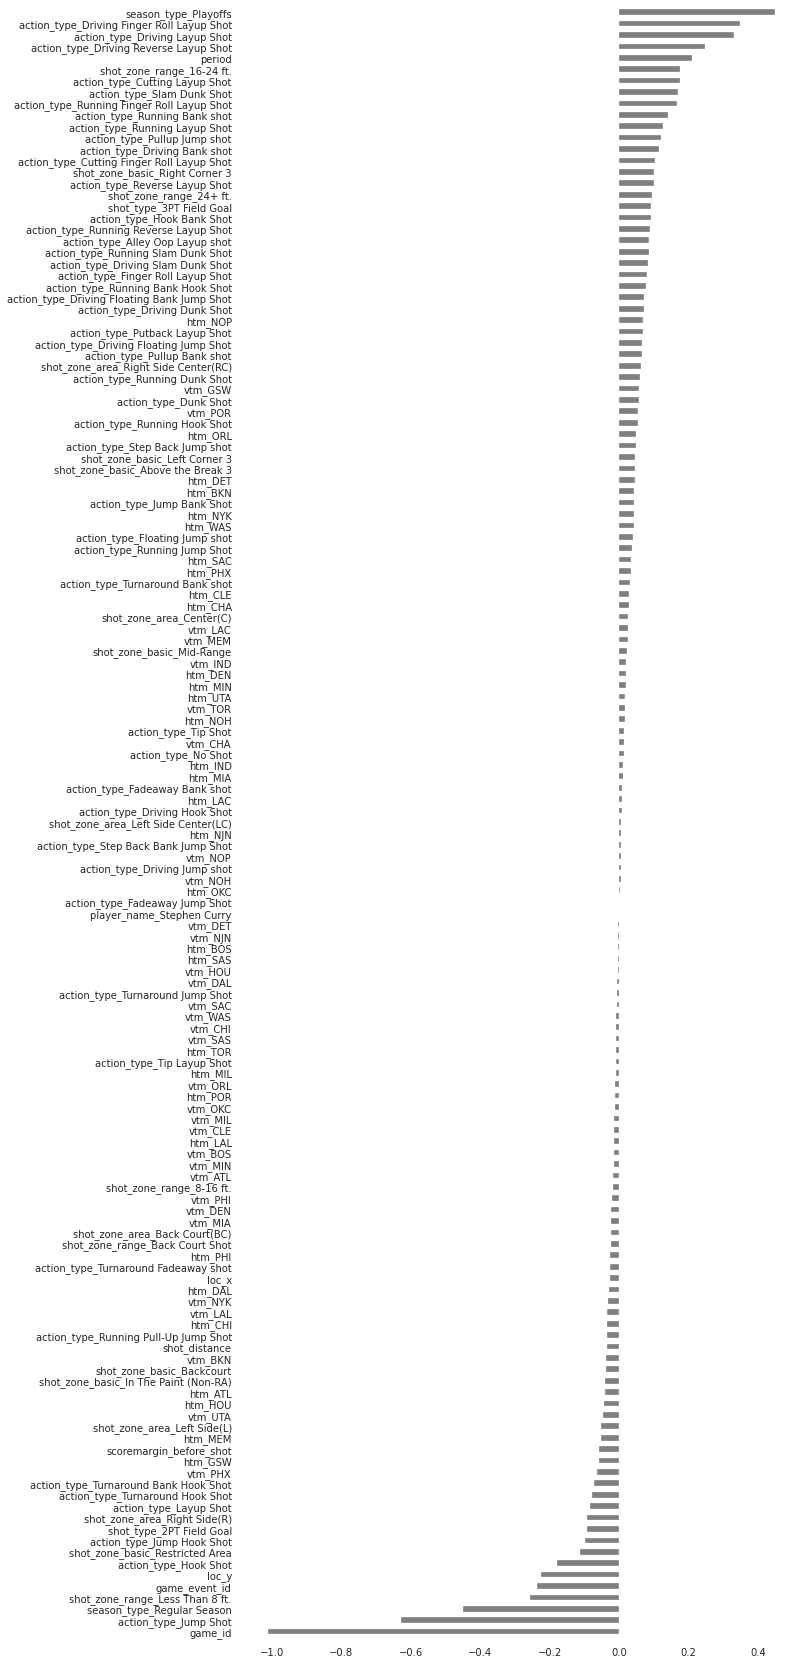

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [0]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.663509246729815


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
cm

array([[836, 333],
       [413, 635]])

In [0]:
normalized_cm = cm/cm.sum(axis=1)[:, np.newaxis]
normalized_cm

array([[0.71514115, 0.28485885],
       [0.39408397, 0.60591603]])

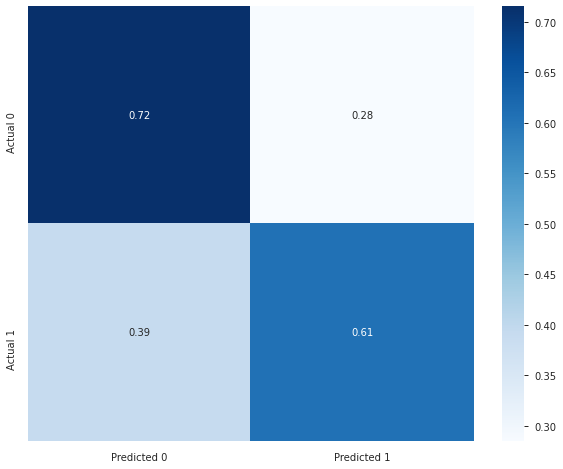

In [0]:
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

def plot_cm(y_val, y_pred, normalize=False):
  cols = unique_labels(y_val)
  cm = confusion_matrix(y_val, y_pred)
  if normalize:
    cm = cm/cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f'
  else:
    fmt = '.0f'
  df_cm = pd.DataFrame(cm, columns = ['Predicted ' + str(col) for col in cols], 
                       index = ['Actual ' + str(col) for col in cols])
  plt.figure(figsize=(10,8))
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt)

plot_cm(y_val, y_pred, normalize=True)

In [0]:
unique_labels(y_val)

array([0, 1])

In [0]:
#correct prediction
np.diag(cm).sum()

1471

In [0]:
#total prediction
cm.sum()

2217

In [0]:
#classification accuracy
np.diag(cm).sum()/cm.sum()

0.663509246729815

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1169
           1       0.66      0.61      0.63      1048

    accuracy                           0.66      2217
   macro avg       0.66      0.66      0.66      2217
weighted avg       0.66      0.66      0.66      2217



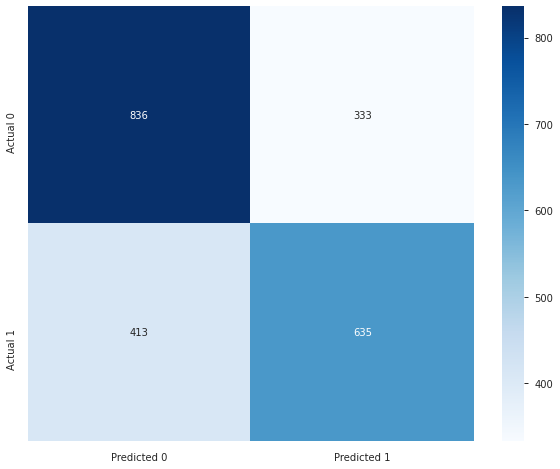

In [0]:
plot_cm(y_val, y_pred)

### Calculate accuracy 

In [0]:
np.diag(cm).sum()/cm.sum()

0.663509246729815

### Calculate precision

In [0]:
correct_pred = 635
total_pred = 635 + 333
precision = correct_pred/total_pred
precision

0.65599173553719

### Calculate recall

In [0]:
actual_1 = 413+635
actual_0 = 836+333
recall_0 = correct_pred/actual_0
recall_0

0.5431993156544055

In [0]:
recall_1 = correct_pred/actual_1
recall_1

0.6059160305343512

In [0]:
score = 2*(precision*recall_1)/(precision+recall_0)
score

0.6629067287736607

In [0]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1169
           1       0.66      0.61      0.63      1048

    accuracy                           0.66      2217
   macro avg       0.66      0.66      0.66      2217
weighted avg       0.66      0.66      0.66      2217



In [0]:
#Precision
actual_positive = 36
total_actual_pred = 58+36
precision = actual_positive/total_actual_pred
precision


0.3829787234042553

In [0]:
#Actual
total_actual_pred

94

In [0]:
# Answer:
tp = 36
tn = 85
fp = 58
fn = 8
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('Accuracy', accuracy)

Accuracy 0.6470588235294118


In [0]:
recall = tp / (tp + fn)
print('Recall', recall)

Recall 0.8181818181818182
